# Download Dataset

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shrutisaxena/yoga-pose-image-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/yoga-pose-image-classification-dataset


# Import Necessary packages for training

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pickle
from torchvision import datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Define image transformations, apply random transformation to prevent overfit

In [45]:
#Transform the dataset to tensorflow and grayscale, apply random transformation to prevent overfit
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomRotation(20),  # Randomly rotate the image by a maximum of 20 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop and resize to 224x224
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Normalize with mean and std
])

# Use GPU if Available

In [46]:
#Check if cuda (GPU) is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# Open the dataset, and split it into 80% training, 20% testing. Find Class Weight to balance the unbalanced of dataset

In [47]:
#Open the dataset
dataset = datasets.ImageFolder("/kaggle/input/yoga-pose-image-classification-dataset/dataset", transform = transform)
#Calculate the amount of image for training, and testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
#Split the dataset into training and testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#Data Loader for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#Print the amount of class
print(len(dataset.classes))

# Calculate class weights to balance the unbalanced amount of class
class_weights = compute_class_weight('balanced', classes=np.arange(len(dataset.classes)), y=dataset.targets)
print(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

107
[0.81145876 0.94899414 1.69668649 0.94899414 1.30210824 0.87485397
 1.39976636 1.07674335 0.62211838 1.19129052 0.84834325 1.69668649
 0.77764798 0.79986649 0.72715135 0.78860076 1.21718813 1.03686397
 1.4356578  0.76699526 0.91787958 0.64357074 1.03686397 0.79986649
 0.62211838 0.93317757 1.21718813 1.4356578  1.01801189 1.09785596
 0.96535611 1.27251487 1.01801189 1.4356578  1.55529595 0.7178289
 0.77764798 0.84834325 1.59973298 1.16647196 0.98229218 1.24423676
 1.39976636 1.55529595 1.30210824 0.98229218 0.82339197 1.14266641
 1.69668649 1.21718813 0.98229218 1.09785596 0.77764798 3.1105919
 0.82339197 1.30210824 0.82339197 1.4356578  1.39976636 0.90307507
 0.99983311 1.59973298 0.99983311 0.99983311 0.98229218 1.59973298
 0.84834325 0.88874054 0.96535611 1.01801189 0.83568141 0.93317757
 0.98229218 0.96535611 1.14266641 1.11981308 0.78860076 1.03686397
 0.90307507 0.93317757 0.99983311 0.98229218 0.93317757 1.80615014
 0.93317757 0.82339197 1.19129052 0.88874054 1.05642744 0.64

# Functions to Train Model and Calculate the loss and accuracies

In [48]:
def train_model(model, loss_function, optimizer, scheduler=None, have_aux=False, epochs=5, patience=2):
    #Stored data for losses, and accuracy each epochs
    train_losses = [] 
    test_losses  = []
    train_accs = []
    test_accs  = []
    #Store the best test accuracy for early termination, and also the amount of epoch without improvement
    best_test_acc = 0.0
    epochs_without_improvement = 0
    #Start from epoch 1
    epoch = 1
    #Train the model
    while epoch <= epochs:
        num_correct_train = 0
        num_samples_train = 0
        model.train()  # Ensure the model is in training mode

        for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=(len(train_loader))):
            # Move data to cuda if available
            X_train = X_train.to(device)
            y_train = y_train.to(device)

            # Forward pass
            if have_aux:
                train_preds = model(X_train)[0]
            else:
                train_preds = model(X_train)
            train_loss = loss_function(train_preds, y_train)

            # Calculate train accuracy
            with torch.no_grad():
                rounded_train_preds = torch.max(train_preds, dim=1)[1]
                num_correct_train += torch.sum(rounded_train_preds == y_train)
                num_samples_train += len(y_train)

            # Backward pass
            optimizer.zero_grad()
            train_loss.backward()

            # Gradient descent
            optimizer.step()

        # Calculate train accuracy
        train_acc = num_correct_train / num_samples_train

        # Get test loss and accuracy
        test_loss, test_acc = predict_test_data(model, test_loader)

        # Update scheduler
        if scheduler:
            scheduler.step(test_loss)

        # Save the training and testing data
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())

        # Print progress
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch} \t|' \
              f' Train loss: {np.round(train_loss.item(), 3)} \t|' \
              f' Test loss: {np.round(test_loss.item(), 3)} \t|' \
              f' Train acc: {np.round(train_acc.item(), 2)} \t|' \
              f' Test acc: {np.round(test_acc.item(), 2)} \t|' \
              f' Learning Rate: {np.round(current_lr, 6)}')

        # Check if test accuracy has improved
        if test_acc > best_test_acc:
            #Update the best accuract and reset epochs without improvement count
            best_test_acc = test_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Early stopping: If no improvement in test accuracy for 'patience' epochs, stop training
        if epochs_without_improvement >= patience:
            print(f"Early stopping: Test accuracy did not improve for {patience} epochs.")
            break

        epoch += 1
        #Confirmation if we should continue the progress
        if epoch > epochs:
            confirm = input("Do you want to continue?")
            if confirm.lower() == "yes":
                epochs += 5
    #Return the model and data saved
    return model, train_losses, test_losses, train_accs, test_accs
#FUnction to calculate test loss and test accuracy
def predict_test_data(model, test_loader):
    
    num_correct = 0
    num_samples = 0

    model.eval()
    #Evaluate images in the test dataset
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)

            # Calculate accuracy
            rounded_test_preds = torch.max(test_preds, dim=1)[1]
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)
    #Convert it back to training mode
    model.train() #b

    test_acc = num_correct/num_samples
    #Return the loss and accuracy
    return test_loss, test_acc

# Train the Resnet Model

In [55]:
#Train the resnet model
resnet = models.resnet18(pretrained=True).to(device)

resnet.fc = nn.Linear(in_features=512, out_features=107).to(device)

resnet.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7),
                         stride=(2, 2), padding=(3, 3), bias=False).to(device)
loss_function = nn.CrossEntropyLoss(weight = class_weights)
optim_resnet    = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_resnet, 'min', patience=2, factor=0.5)
resnet_history    = train_model(resnet, loss_function, optim_resnet,
                                have_aux=False, epochs=10, scheduler=scheduler)
# Save training history
with open("resnet_history.pkl", "wb") as f:
    pickle.dump(resnet_history, f)

100%|██████████| 150/150 [00:36<00:00,  4.14it/s]


Epoch: 1 	| Train loss: 3.094 	| Test loss: 3.436 	| Train acc: 0.11 	| Test acc: 0.19 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.08it/s]


Epoch: 2 	| Train loss: 2.136 	| Test loss: 1.985 	| Train acc: 0.32 	| Test acc: 0.31 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.09it/s]


Epoch: 3 	| Train loss: 2.061 	| Test loss: 1.586 	| Train acc: 0.43 	| Test acc: 0.42 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


Epoch: 4 	| Train loss: 2.097 	| Test loss: 1.651 	| Train acc: 0.52 	| Test acc: 0.47 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.15it/s]


Epoch: 5 	| Train loss: 1.369 	| Test loss: 1.415 	| Train acc: 0.56 	| Test acc: 0.51 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.14it/s]


Epoch: 6 	| Train loss: 1.569 	| Test loss: 1.195 	| Train acc: 0.61 	| Test acc: 0.5 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


Epoch: 7 	| Train loss: 1.657 	| Test loss: 1.465 	| Train acc: 0.66 	| Test acc: 0.52 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.12it/s]


Epoch: 8 	| Train loss: 1.531 	| Test loss: 1.495 	| Train acc: 0.69 	| Test acc: 0.55 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  4.05it/s]


Epoch: 9 	| Train loss: 0.919 	| Test loss: 0.731 	| Train acc: 0.72 	| Test acc: 0.57 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


Epoch: 10 	| Train loss: 1.084 	| Test loss: 0.901 	| Train acc: 0.75 	| Test acc: 0.58 	| Learning Rate: 0.001


Do you want to continue? yes


100%|██████████| 150/150 [00:37<00:00,  4.05it/s]


Epoch: 11 	| Train loss: 0.998 	| Test loss: 1.03 	| Train acc: 0.76 	| Test acc: 0.58 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


Epoch: 12 	| Train loss: 0.711 	| Test loss: 0.771 	| Train acc: 0.79 	| Test acc: 0.6 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:36<00:00,  4.17it/s]


Epoch: 13 	| Train loss: 0.338 	| Test loss: 0.829 	| Train acc: 0.86 	| Test acc: 0.64 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:36<00:00,  4.14it/s]


Epoch: 14 	| Train loss: 0.36 	| Test loss: 1.147 	| Train acc: 0.9 	| Test acc: 0.64 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


Epoch: 15 	| Train loss: 0.288 	| Test loss: 1.024 	| Train acc: 0.92 	| Test acc: 0.64 	| Learning Rate: 0.00025


Do you want to continue? no


# Train EfficientNet Model

In [56]:
#Train efficientNetB0 model
efficientnet = models.efficientnet_b0(pretrained=True).to(device)
efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=107).to(device)
efficientnet.features[0][0] = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), 
                                        stride=(2, 2), padding=(1, 1), bias=False).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optim_efficientnet = optim.Adam(efficientnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_efficientnet, 'min', patience=2, factor=0.5)
efficientnet_history = train_model(efficientnet, loss_function, optim_efficientnet, 
                                   have_aux=False, epochs=10, scheduler=scheduler)
with open("efficientnet_history.pkl", "wb") as f:
    pickle.dump(efficientnet_history, f)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 48.8MB/s]
100%|██████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch: 1 	| Train loss: 1.783 	| Test loss: 2.212 	| Train acc: 0.19 	| Test acc: 0.41 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch: 2 	| Train loss: 1.536 	| Test loss: 1.43 	| Train acc: 0.5 	| Test acc: 0.55 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch: 3 	| Train loss: 0.967 	| Test loss: 1.166 	| Train acc: 0.62 	| Test acc: 0.6 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:40<00:00,  3.73it/s]


Epoch: 4 	| Train loss: 0.916 	| Test loss: 1.293 	| Train acc: 0.69 	| Test acc: 0.63 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch: 5 	| Train loss: 0.523 	| Test loss: 0.588 	| Train acc: 0.74 	| Test acc: 0.64 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch: 6 	| Train loss: 1.176 	| Test loss: 0.94 	| Train acc: 0.77 	| Test acc: 0.65 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.78it/s]


Epoch: 7 	| Train loss: 0.791 	| Test loss: 0.773 	| Train acc: 0.8 	| Test acc: 0.67 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:39<00:00,  3.85it/s]


Epoch: 8 	| Train loss: 0.351 	| Test loss: 1.215 	| Train acc: 0.83 	| Test acc: 0.67 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch: 9 	| Train loss: 0.182 	| Test loss: 0.806 	| Train acc: 0.89 	| Test acc: 0.7 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch: 10 	| Train loss: 0.207 	| Test loss: 0.57 	| Train acc: 0.92 	| Test acc: 0.71 	| Learning Rate: 0.0005


Do you want to continue? no


# Train VGG model

In [59]:
#Train the VGG16 moment
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.classifier[6] = nn.Linear(in_features=512, out_features=107).to(device)
vgg16.features[0] = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    nn.ReLU(inplace=True)
).to(device)
vgg16.classifier[0] = nn.Linear(in_features=25088, out_features=512).to(device)
vgg16.classifier[3] = nn.Linear(in_features=512, out_features=512).to(device)
for param in vgg16.features.parameters():
    param.requires_grad = False
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optim_vgg16 = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)  # Only train the classifier layers
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_vgg16, 'min', patience=2, factor=0.5)
vgg16_history = train_model(vgg16, loss_function, optim_vgg16, 
                             have_aux=False, epochs=25, scheduler=scheduler, patience=5
                           )

# Save the training history
with open("vgg16_history.pkl", "wb") as f:
    pickle.dump(vgg16_history, f)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s]  
100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Epoch: 1 	| Train loss: 4.656 	| Test loss: 4.605 	| Train acc: 0.01 	| Test acc: 0.03 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.28it/s]


Epoch: 2 	| Train loss: 4.5 	| Test loss: 4.531 	| Train acc: 0.03 	| Test acc: 0.07 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Epoch: 3 	| Train loss: 4.062 	| Test loss: 4.208 	| Train acc: 0.05 	| Test acc: 0.1 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Epoch: 4 	| Train loss: 3.858 	| Test loss: 3.835 	| Train acc: 0.07 	| Test acc: 0.15 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:34<00:00,  4.34it/s]


Epoch: 5 	| Train loss: 4.185 	| Test loss: 3.526 	| Train acc: 0.09 	| Test acc: 0.19 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.28it/s]


Epoch: 6 	| Train loss: 3.59 	| Test loss: 3.269 	| Train acc: 0.12 	| Test acc: 0.2 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Epoch: 7 	| Train loss: 3.331 	| Test loss: 3.117 	| Train acc: 0.15 	| Test acc: 0.23 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.28it/s]


Epoch: 8 	| Train loss: 3.558 	| Test loss: 2.923 	| Train acc: 0.18 	| Test acc: 0.28 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.18it/s]


Epoch: 9 	| Train loss: 3.156 	| Test loss: 2.756 	| Train acc: 0.19 	| Test acc: 0.28 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


Epoch: 10 	| Train loss: 3.076 	| Test loss: 2.665 	| Train acc: 0.21 	| Test acc: 0.27 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Epoch: 11 	| Train loss: 3.177 	| Test loss: 2.65 	| Train acc: 0.21 	| Test acc: 0.3 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.26it/s]


Epoch: 12 	| Train loss: 2.911 	| Test loss: 2.626 	| Train acc: 0.24 	| Test acc: 0.32 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Epoch: 13 	| Train loss: 2.546 	| Test loss: 2.343 	| Train acc: 0.25 	| Test acc: 0.32 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.24it/s]


Epoch: 14 	| Train loss: 3.288 	| Test loss: 2.464 	| Train acc: 0.26 	| Test acc: 0.33 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:36<00:00,  4.13it/s]


Epoch: 15 	| Train loss: 2.884 	| Test loss: 2.473 	| Train acc: 0.29 	| Test acc: 0.33 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:36<00:00,  4.16it/s]


Epoch: 16 	| Train loss: 2.356 	| Test loss: 2.234 	| Train acc: 0.29 	| Test acc: 0.35 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.17it/s]


Epoch: 17 	| Train loss: 2.689 	| Test loss: 2.14 	| Train acc: 0.31 	| Test acc: 0.37 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


Epoch: 18 	| Train loss: 2.687 	| Test loss: 2.195 	| Train acc: 0.31 	| Test acc: 0.36 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.19it/s]


Epoch: 19 	| Train loss: 2.175 	| Test loss: 1.926 	| Train acc: 0.32 	| Test acc: 0.37 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.26it/s]


Epoch: 20 	| Train loss: 2.476 	| Test loss: 1.924 	| Train acc: 0.33 	| Test acc: 0.36 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Epoch: 21 	| Train loss: 2.18 	| Test loss: 2.016 	| Train acc: 0.36 	| Test acc: 0.35 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.17it/s]


Epoch: 22 	| Train loss: 2.809 	| Test loss: 1.974 	| Train acc: 0.35 	| Test acc: 0.37 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.23it/s]


Epoch: 23 	| Train loss: 2.554 	| Test loss: 1.81 	| Train acc: 0.37 	| Test acc: 0.39 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.22it/s]


Epoch: 24 	| Train loss: 2.307 	| Test loss: 1.626 	| Train acc: 0.37 	| Test acc: 0.39 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.19it/s]


Epoch: 25 	| Train loss: 2.211 	| Test loss: 1.627 	| Train acc: 0.39 	| Test acc: 0.39 	| Learning Rate: 0.0001


Do you want to continue? yes


100%|██████████| 150/150 [00:35<00:00,  4.18it/s]


Epoch: 26 	| Train loss: 2.649 	| Test loss: 1.947 	| Train acc: 0.39 	| Test acc: 0.39 	| Learning Rate: 0.0001


100%|██████████| 150/150 [00:35<00:00,  4.21it/s]


Epoch: 27 	| Train loss: 1.677 	| Test loss: 1.721 	| Train acc: 0.4 	| Test acc: 0.4 	| Learning Rate: 5e-05


100%|██████████| 150/150 [00:36<00:00,  4.13it/s]


Epoch: 28 	| Train loss: 2.323 	| Test loss: 1.629 	| Train acc: 0.41 	| Test acc: 0.41 	| Learning Rate: 5e-05


100%|██████████| 150/150 [00:36<00:00,  4.14it/s]


Epoch: 29 	| Train loss: 1.893 	| Test loss: 2.086 	| Train acc: 0.42 	| Test acc: 0.4 	| Learning Rate: 5e-05


100%|██████████| 150/150 [00:36<00:00,  4.16it/s]


Epoch: 30 	| Train loss: 1.788 	| Test loss: 1.729 	| Train acc: 0.43 	| Test acc: 0.39 	| Learning Rate: 2.5e-05


Do you want to continue? yes


100%|██████████| 150/150 [00:36<00:00,  4.12it/s]


Epoch: 31 	| Train loss: 2.207 	| Test loss: 1.589 	| Train acc: 0.44 	| Test acc: 0.41 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:35<00:00,  4.21it/s]


Epoch: 32 	| Train loss: 2.048 	| Test loss: 1.567 	| Train acc: 0.44 	| Test acc: 0.4 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Epoch: 33 	| Train loss: 2.081 	| Test loss: 1.768 	| Train acc: 0.43 	| Test acc: 0.41 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:36<00:00,  4.14it/s]


Epoch: 34 	| Train loss: 1.592 	| Test loss: 1.576 	| Train acc: 0.44 	| Test acc: 0.41 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:36<00:00,  4.07it/s]


Epoch: 35 	| Train loss: 1.966 	| Test loss: 1.535 	| Train acc: 0.45 	| Test acc: 0.42 	| Learning Rate: 2.5e-05


Do you want to continue? yes


100%|██████████| 150/150 [00:38<00:00,  3.91it/s]


Epoch: 36 	| Train loss: 1.934 	| Test loss: 1.57 	| Train acc: 0.44 	| Test acc: 0.41 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:37<00:00,  4.04it/s]


Epoch: 37 	| Train loss: 2.044 	| Test loss: 1.533 	| Train acc: 0.44 	| Test acc: 0.41 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


Epoch: 38 	| Train loss: 1.791 	| Test loss: 1.783 	| Train acc: 0.44 	| Test acc: 0.42 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:37<00:00,  4.03it/s]


Epoch: 39 	| Train loss: 1.827 	| Test loss: 1.559 	| Train acc: 0.45 	| Test acc: 0.41 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:36<00:00,  4.12it/s]


Epoch: 40 	| Train loss: 2.164 	| Test loss: 1.532 	| Train acc: 0.46 	| Test acc: 0.42 	| Learning Rate: 2.5e-05


Do you want to continue? yes


100%|██████████| 150/150 [00:35<00:00,  4.25it/s]


Epoch: 41 	| Train loss: 1.465 	| Test loss: 1.813 	| Train acc: 0.46 	| Test acc: 0.42 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:35<00:00,  4.20it/s]


Epoch: 42 	| Train loss: 2.351 	| Test loss: 1.608 	| Train acc: 0.45 	| Test acc: 0.42 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:36<00:00,  4.06it/s]


Epoch: 43 	| Train loss: 1.814 	| Test loss: 1.523 	| Train acc: 0.46 	| Test acc: 0.42 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:35<00:00,  4.17it/s]


Epoch: 44 	| Train loss: 1.975 	| Test loss: 1.653 	| Train acc: 0.47 	| Test acc: 0.43 	| Learning Rate: 2.5e-05


100%|██████████| 150/150 [00:37<00:00,  3.99it/s]


Epoch: 45 	| Train loss: 1.907 	| Test loss: 1.672 	| Train acc: 0.46 	| Test acc: 0.43 	| Learning Rate: 2.5e-05


Do you want to continue? yes


100%|██████████| 150/150 [00:51<00:00,  2.92it/s]


Epoch: 46 	| Train loss: 1.845 	| Test loss: 1.682 	| Train acc: 0.46 	| Test acc: 0.41 	| Learning Rate: 1.2e-05


100%|██████████| 150/150 [00:35<00:00,  4.24it/s]


Epoch: 47 	| Train loss: 1.848 	| Test loss: 1.789 	| Train acc: 0.47 	| Test acc: 0.42 	| Learning Rate: 1.2e-05


100%|██████████| 150/150 [00:35<00:00,  4.22it/s]


Epoch: 48 	| Train loss: 1.643 	| Test loss: 1.408 	| Train acc: 0.46 	| Test acc: 0.41 	| Learning Rate: 1.2e-05


100%|██████████| 150/150 [00:35<00:00,  4.21it/s]


Epoch: 49 	| Train loss: 2.265 	| Test loss: 1.463 	| Train acc: 0.47 	| Test acc: 0.43 	| Learning Rate: 1.2e-05
Early stopping: Test accuracy did not improve for 5 epochs.


# Train MobileNet Model

In [58]:
#Train MobileNet V2 Model
mobilenet = models.mobilenet_v2(pretrained=True).to(device)
mobilenet.features[0][0] = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3),
                                     stride=(2, 2), padding=(1, 1), bias=False).to(device)
mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=107).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optim_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_mobilenet, 'min', patience=2, factor=0.5)
mobilenet_history = train_model(mobilenet, loss_function, optim_mobilenet,
                                have_aux=False, epochs=10, scheduler=scheduler)

# Save training history
with open("mobilenet_history.pkl", "wb") as f:
    pickle.dump(mobilenet_history, f)

100%|██████████| 150/150 [00:37<00:00,  4.04it/s]


Epoch: 1 	| Train loss: 3.119 	| Test loss: 2.616 	| Train acc: 0.09 	| Test acc: 0.2 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:38<00:00,  3.94it/s]


Epoch: 2 	| Train loss: 1.73 	| Test loss: 2.739 	| Train acc: 0.28 	| Test acc: 0.34 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  3.97it/s]


Epoch: 3 	| Train loss: 1.886 	| Test loss: 1.285 	| Train acc: 0.41 	| Test acc: 0.43 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  4.01it/s]


Epoch: 4 	| Train loss: 1.447 	| Test loss: 1.26 	| Train acc: 0.48 	| Test acc: 0.49 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  3.99it/s]


Epoch: 5 	| Train loss: 2.001 	| Test loss: 1.065 	| Train acc: 0.52 	| Test acc: 0.52 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  3.99it/s]


Epoch: 6 	| Train loss: 1.173 	| Test loss: 0.966 	| Train acc: 0.58 	| Test acc: 0.49 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  3.96it/s]


Epoch: 7 	| Train loss: 1.831 	| Test loss: 0.909 	| Train acc: 0.59 	| Test acc: 0.54 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:38<00:00,  3.91it/s]


Epoch: 8 	| Train loss: 1.247 	| Test loss: 0.717 	| Train acc: 0.63 	| Test acc: 0.57 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  3.97it/s]


Epoch: 9 	| Train loss: 0.877 	| Test loss: 1.412 	| Train acc: 0.66 	| Test acc: 0.58 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:37<00:00,  3.96it/s]


Epoch: 10 	| Train loss: 0.733 	| Test loss: 0.899 	| Train acc: 0.67 	| Test acc: 0.58 	| Learning Rate: 0.001


Do you want to continue? yes


100%|██████████| 150/150 [00:37<00:00,  3.95it/s]


Epoch: 11 	| Train loss: 1.812 	| Test loss: 1.557 	| Train acc: 0.68 	| Test acc: 0.57 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:37<00:00,  3.96it/s]


Epoch: 12 	| Train loss: 0.62 	| Test loss: 0.76 	| Train acc: 0.77 	| Test acc: 0.65 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:38<00:00,  3.92it/s]


Epoch: 13 	| Train loss: 0.527 	| Test loss: 0.747 	| Train acc: 0.81 	| Test acc: 0.66 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:38<00:00,  3.91it/s]


Epoch: 14 	| Train loss: 0.62 	| Test loss: 0.894 	| Train acc: 0.82 	| Test acc: 0.67 	| Learning Rate: 0.00025


100%|██████████| 150/150 [00:38<00:00,  3.92it/s]


Epoch: 15 	| Train loss: 0.522 	| Test loss: 1.087 	| Train acc: 0.86 	| Test acc: 0.68 	| Learning Rate: 0.00025


Do you want to continue? yes


100%|██████████| 150/150 [00:37<00:00,  3.95it/s]


Epoch: 16 	| Train loss: 0.295 	| Test loss: 1.132 	| Train acc: 0.88 	| Test acc: 0.69 	| Learning Rate: 0.00025


100%|██████████| 150/150 [00:38<00:00,  3.94it/s]


Epoch: 17 	| Train loss: 0.546 	| Test loss: 0.924 	| Train acc: 0.89 	| Test acc: 0.68 	| Learning Rate: 0.000125


100%|██████████| 150/150 [00:38<00:00,  3.90it/s]


Epoch: 18 	| Train loss: 0.235 	| Test loss: 1.012 	| Train acc: 0.9 	| Test acc: 0.7 	| Learning Rate: 0.000125


100%|██████████| 150/150 [00:38<00:00,  3.91it/s]


Epoch: 19 	| Train loss: 0.492 	| Test loss: 1.025 	| Train acc: 0.91 	| Test acc: 0.7 	| Learning Rate: 0.000125


100%|██████████| 150/150 [00:38<00:00,  3.92it/s]


Epoch: 20 	| Train loss: 0.079 	| Test loss: 0.949 	| Train acc: 0.92 	| Test acc: 0.69 	| Learning Rate: 6.2e-05
Early stopping: Test accuracy did not improve for 2 epochs.


# Train EfficientNetB5 model

In [71]:
#Train EfficientNetB5 Model
efficientnetb5 = models.efficientnet_b5(pretrained=True).to(device)
efficientnetb5.classifier[1] = nn.Linear(in_features=2048, out_features=107).to(device)
efficientnetb5.features[0][0] = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=(3, 3), 
                                          stride=(2, 2), padding=(1, 1), bias=False).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optim_efficientnetb5 = optim.Adam(efficientnetb5.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_efficientnetb5, 'min', patience=2, factor=0.5)
efficientnetb5_history = train_model(efficientnetb5, loss_function, optim_efficientnetb5, 
                                     have_aux=False, epochs=10, scheduler=scheduler)
# Save training history
with open("efficientnetb5_history.pkl", "wb") as f:
    pickle.dump(efficientnetb5_history, f)

100%|██████████| 150/150 [01:30<00:00,  1.66it/s]


Epoch: 1 	| Train loss: 1.843 	| Test loss: 2.931 	| Train acc: 0.23 	| Test acc: 0.29 	| Learning Rate: 0.001


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 2 	| Train loss: 1.434 	| Test loss: 1.703 	| Train acc: 0.52 	| Test acc: 0.47 	| Learning Rate: 0.001


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 3 	| Train loss: 1.504 	| Test loss: 0.996 	| Train acc: 0.62 	| Test acc: 0.6 	| Learning Rate: 0.001


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 4 	| Train loss: 1.417 	| Test loss: 0.816 	| Train acc: 0.7 	| Test acc: 0.58 	| Learning Rate: 0.001


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 5 	| Train loss: 1.336 	| Test loss: 0.958 	| Train acc: 0.74 	| Test acc: 0.62 	| Learning Rate: 0.001


100%|██████████| 150/150 [01:29<00:00,  1.68it/s]


Epoch: 6 	| Train loss: 1.06 	| Test loss: 0.967 	| Train acc: 0.77 	| Test acc: 0.63 	| Learning Rate: 0.001


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 7 	| Train loss: 0.303 	| Test loss: 1.219 	| Train acc: 0.82 	| Test acc: 0.64 	| Learning Rate: 0.0005


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 8 	| Train loss: 0.254 	| Test loss: 0.966 	| Train acc: 0.88 	| Test acc: 0.73 	| Learning Rate: 0.0005


100%|██████████| 150/150 [01:29<00:00,  1.67it/s]


Epoch: 9 	| Train loss: 0.339 	| Test loss: 0.878 	| Train acc: 0.92 	| Test acc: 0.7 	| Learning Rate: 0.0005


100%|██████████| 150/150 [02:00<00:00,  1.24it/s]


Epoch: 10 	| Train loss: 0.15 	| Test loss: 1.241 	| Train acc: 0.94 	| Test acc: 0.72 	| Learning Rate: 0.00025
Early stopping: Test accuracy did not improve for 2 epochs.


# Train efficientNet V2 S

In [53]:
#Train EfficientNet V2 S Model
efficientv2_s = models.efficientnet_v2_s(pretrained=True).to(device)
efficientv2_s.features[0][0] = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=(3, 3), 
                                         stride=(2, 2), padding=(1, 1), bias=False).to(device)
efficientv2_s.features[0][1] = nn.BatchNorm2d(24).to(device)
efficientv2_s.classifier[1] = nn.Linear(in_features=1280, out_features=107).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optim_efficientv2_s = optim.Adam(efficientv2_s.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim_efficientv2_s, 'min', patience=2, factor=0.5)
efficientv2_s_history = train_model(efficientv2_s, loss_function, optim_efficientv2_s, 
                                    have_aux=False, epochs=15, scheduler=scheduler, patience=5)

# Save training history
with open("efficientv2_s_history.pkl", "wb") as f:
    pickle.dump(efficientv2_s_history, f)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 150/150 [00:57<00:00,  2.61it/s]


Epoch: 1 	| Train loss: 2.83 	| Test loss: 2.697 	| Train acc: 0.15 	| Test acc: 0.3 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Epoch: 2 	| Train loss: 2.031 	| Test loss: 1.448 	| Train acc: 0.41 	| Test acc: 0.45 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 3 	| Train loss: 1.245 	| Test loss: 1.204 	| Train acc: 0.53 	| Test acc: 0.53 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 4 	| Train loss: 0.847 	| Test loss: 0.812 	| Train acc: 0.61 	| Test acc: 0.6 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 5 	| Train loss: 1.432 	| Test loss: 0.621 	| Train acc: 0.66 	| Test acc: 0.64 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:57<00:00,  2.62it/s]


Epoch: 6 	| Train loss: 1.567 	| Test loss: 0.75 	| Train acc: 0.71 	| Test acc: 0.66 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:56<00:00,  2.66it/s]


Epoch: 7 	| Train loss: 1.02 	| Test loss: 0.692 	| Train acc: 0.73 	| Test acc: 0.65 	| Learning Rate: 0.001


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 8 	| Train loss: 0.749 	| Test loss: 0.864 	| Train acc: 0.76 	| Test acc: 0.66 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 9 	| Train loss: 0.579 	| Test loss: 0.927 	| Train acc: 0.85 	| Test acc: 0.71 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:57<00:00,  2.63it/s]


Epoch: 10 	| Train loss: 0.411 	| Test loss: 0.67 	| Train acc: 0.88 	| Test acc: 0.7 	| Learning Rate: 0.0005


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 11 	| Train loss: 0.386 	| Test loss: 0.652 	| Train acc: 0.91 	| Test acc: 0.71 	| Learning Rate: 0.00025


100%|██████████| 150/150 [00:56<00:00,  2.64it/s]


Epoch: 12 	| Train loss: 0.111 	| Test loss: 0.654 	| Train acc: 0.94 	| Test acc: 0.73 	| Learning Rate: 0.00025


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 13 	| Train loss: 0.125 	| Test loss: 0.713 	| Train acc: 0.94 	| Test acc: 0.72 	| Learning Rate: 0.00025


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 14 	| Train loss: 0.119 	| Test loss: 0.968 	| Train acc: 0.94 	| Test acc: 0.72 	| Learning Rate: 0.000125


100%|██████████| 150/150 [00:56<00:00,  2.65it/s]


Epoch: 15 	| Train loss: 0.093 	| Test loss: 0.596 	| Train acc: 0.96 	| Test acc: 0.73 	| Learning Rate: 0.000125


Do you want to continue? no


In [ ]:
#Open all the  model and send it to the device
with open("efficientnet_history.pkl", "rb") as f:
    efficientnet_history = list(pickle.load(f))
efficientnet_history[0] = efficientnet_history[0].to(device)
with open("resnet_history.pkl", "rb") as f:
    resnet_history = list(pickle.load(f))
resnet_history[0] = resnet_history[0].to(device)
with open("vgg16_history.pkl", "rb") as f:
    vgg16_history = list(pickle.load(f))
vgg16_history[0] = vgg16_history[0].to(device)
with open("mobilenet_history.pkl", "rb") as f:
    mobilenet_history = list(pickle.load(f))
mobilenet_history[0] = mobilenet_history[0].to(device)
with open("efficientnetb5_history.pkl", "rb") as f:
    efficientnetb5_history = list(pickle.load(f))
efficientnetb5_history[0] = efficientnetb5_history[0].to(device)
with open("efficientv2_s_history.pkl", "rb") as f:
    efficientv2_s_history = list(pickle.load(f))
efficientv2_s_history[0]=efficientv2_s_history[0].to(device)

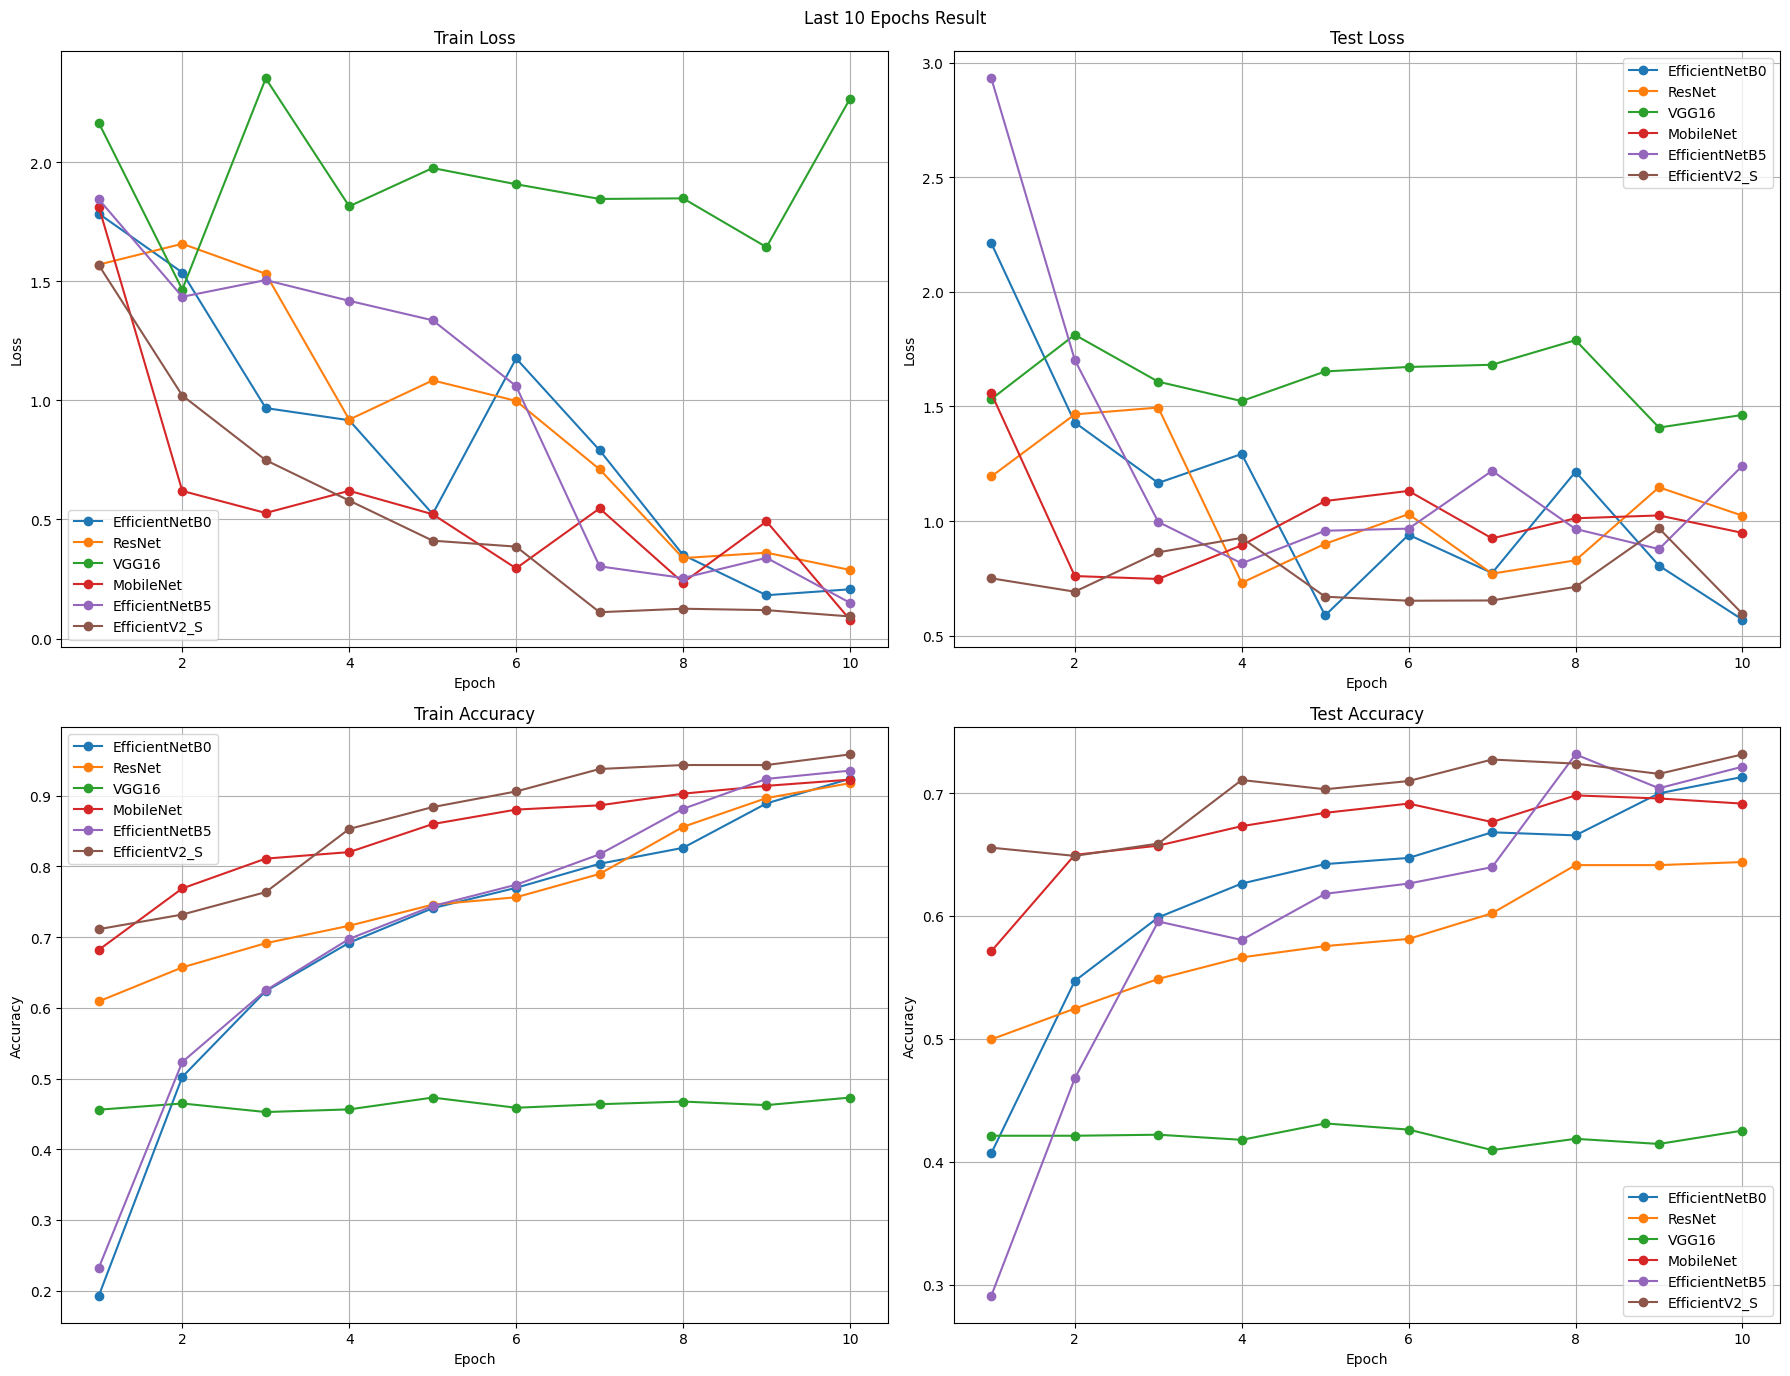

In [88]:
import matplotlib.pyplot as plt

#Dictionary of model name and the history
histories = {
    'EfficientNetB0': efficientnet_history,
    'ResNet': resnet_history,
    'VGG16': vgg16_history,
    'MobileNet': mobilenet_history,
    'EfficientNetB5': efficientnetb5_history,
    'EfficientV2_S': efficientv2_s_history
}

#Information of the index of the data
metric_info = {
    1: {'label': 'Train Loss', 'ylabel': 'Loss'},
    2: {'label': 'Test Loss', 'ylabel': 'Loss'},
    3: {'label': 'Train Accuracy', 'ylabel': 'Accuracy'},
    4: {'label': 'Test Accuracy', 'ylabel': 'Accuracy'},
}

#The axis should be 1 until 10
epoch_axis = list(range(1, 11))

#Create a 2 x 2 figure
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

#Iterate through the metric indexes
for i, metric_index in enumerate([1, 2, 3, 4]):
    ax = axes[i]
    # For each model, plot the last 10 values of the corresponding metric.
    for model_name, history in histories.items():
        #Get the list of metrics value
        metric_values = history[metric_index]
        #Get the last 10 of metric values
        last_10 = metric_values[-10:]
        #Plot the model
        ax.plot(epoch_axis, last_10, marker='o', label=model_name)
    ax.set_title(metric_info[metric_index]['label'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_info[metric_index]['ylabel'])
    ax.grid(True)
    ax.legend()
plt.suptitle("Last 10 Epochs Result")
plt.tight_layout()
plt.show()

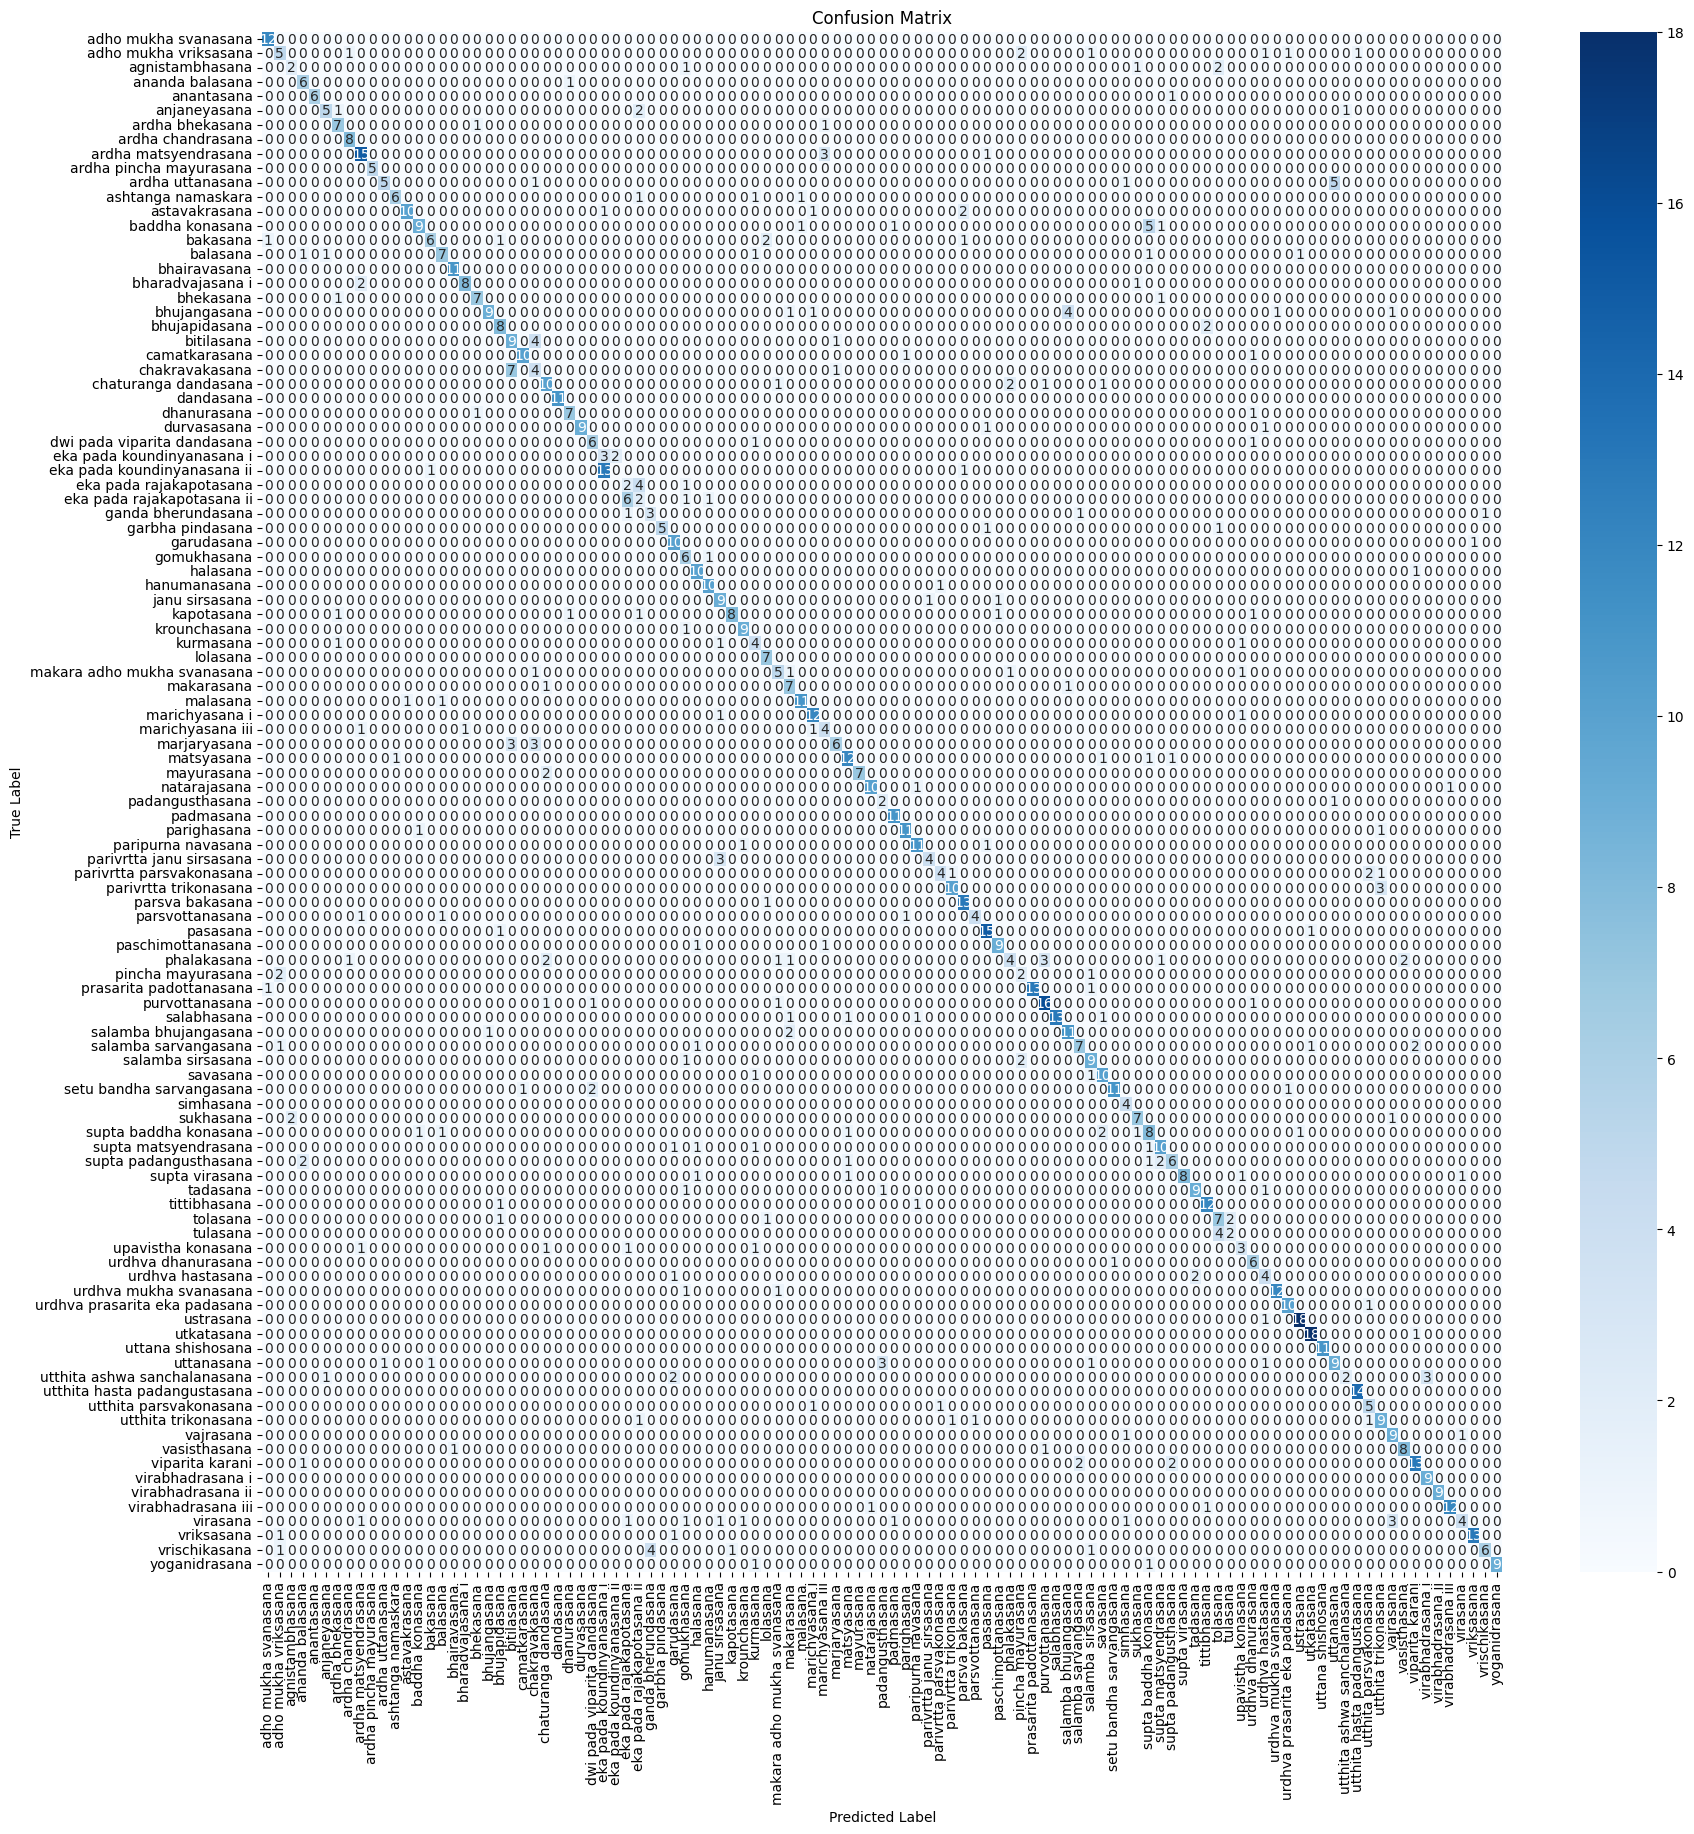

                               precision    recall  f1-score   support

         adho mukha svanasana       0.86      1.00      0.92        12
        adho mukha vriksasana       0.50      0.42      0.45        12
              agnistambhasana       0.50      0.33      0.40         6
              ananda balasana       0.60      0.86      0.71         7
                   anantasana       1.00      0.86      0.92         7
                 anjaneyasana       0.71      0.56      0.63         9
              ardha bhekasana       0.64      0.78      0.70         9
            ardha chandrasana       0.80      1.00      0.89         8
         ardha matsyendrasana       0.71      0.79      0.75        19
      ardha pincha mayurasana       1.00      1.00      1.00         5
             ardha uttanasana       0.83      0.42      0.56        12
           ashtanga namaskara       0.86      0.67      0.75         9
                astavakrasana       0.91      0.71      0.80        14
     

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Collect Predictions and True Labels
y_true = []
y_pred = []
efficientv2_s_history[0].eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = efficientv2_s_history[0](images)
        _, preds = torch.max(outputs, 1)  # Get the class index with highest score
        
        y_true.extend(labels.cpu().numpy())  # Move to CPU and store
        y_pred.extend(preds.cpu().numpy())

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=dataset.classes))

In [87]:
from ipywidgets import FileUpload, Output
from IPython.display import display, Image, Markdown
from PIL import Image as PILImage
import io
import cv2
import numpy as np
import torch

# Create upload widget
upload_widget = FileUpload()

# Create an output widget to display text
output = Output()
transformed_image = None

def on_upload_change(change):
    with output:
        global transformed_image
        output.clear_output()
        if upload_widget.value:
            # Access the uploaded file content
            uploaded_file = upload_widget.value[0]  # Access file dictionary
            content = uploaded_file['content']

            # Convert the byte data to an image
            img = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_COLOR)
            _, img_encoded = cv2.imencode('.png', img)
            
            efficientnetb5_history[0].eval()
            img_bytes = img_encoded.tobytes()  # Convert to bytes for display
            img_pil = PILImage.open(io.BytesIO(img_bytes))
            transformed_image = transform(img_pil).unsqueeze(0).to(device)
            display(Image(data=img_bytes))

            with torch.no_grad():
                output2 = efficientnetb5_history[0](transformed_image)
            
            probabilities = torch.nn.functional.softmax(output2, dim=1)  # Convert logits to probabilities
            
            # Get top 3 probabilities and corresponding class indices
            top3_probs, top3_indices = torch.topk(probabilities, 3)
            
            # Convert to percentages
            top3_probs = (top3_probs * 100).squeeze().tolist()
            top3_indices = top3_indices.squeeze().tolist()
            
            # Display top 3 predictions
            markdown_text = "**Top 3 Predictions:**\n\n"
            for i in range(3):
                class_name = dataset.classes[top3_indices[i]]
                probability = top3_probs[i]
                markdown_text += f"- **{class_name.capitalize()}**: {probability:.2f}%\n"
            
            display(Markdown(markdown_text))
        else:
            display("No file uploaded")

# Observe the file upload widget for changes
upload_widget.observe(on_upload_change, names='value')

# Display widgets
display(upload_widget, output)

FileUpload(value=(), description='Upload')

Output()